In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydicom
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics import f1_score
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
from tensorflow.keras.models import Sequential,save_model

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('../input/merge-labels-and-paths/merge_labels_and_paths.csv')
df.drop(['files_num'],axis=1,inplace=True)
df.head()

,BraTS21ID,MGMT_value,best_flair_images,best_t1w_images,best_t1wce_images,best_t2w_images
0,0,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,2,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,3,0,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
3,5,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
4,6,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...


In [4]:
df.shape

(582, 6)

In [5]:
df['best_flair_images'][0]

'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/Image-140.dcm'

In [6]:
def load_images(list_paths):
    images=[]
    for path in list_paths:
        img=pydicom.dcmread(path)
        img=img_to_array(img.pixel_array)
        img=tf.image.resize(img,(256,256))
        images.append(img)
    return np.array(images)

In [7]:
flair_images=load_images(df['best_flair_images'])
t1w_images=load_images(df['best_t1w_images'])
t1wce_images=load_images(df['best_t1wce_images'])
t2w_images=load_images(df['best_t2w_images'])

2022-09-07 01:54:30.935011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 01:54:31.075286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 01:54:31.076252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 01:54:31.085680: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
print(flair_images.shape,type(flair_images))

(582, 256, 256, 1) <class 'numpy.ndarray'>


In [9]:
labels=df['MGMT_value']
labels = labels.astype(np.int32)
print(labels.shape)
labels.head()

(582,)


0    1
1    1
2    0
3    1
4    1
Name: MGMT_value, dtype: int32

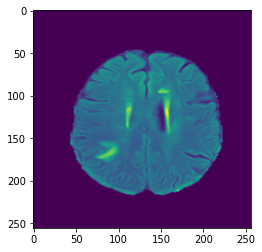

In [10]:
plt.imshow(flair_images[200])

In [11]:
flairs_ds=tf.data.Dataset.from_tensor_slices((flair_images,labels))

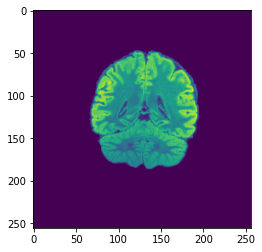

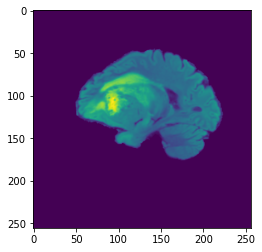

In [12]:
for im,label in flairs_ds.take(2):
    plt.figure()
    plt.imshow(im)

In [13]:
def prepare_train_val_test_input_pipelines(images,labels):
    AUTOTUNE=tf.data.AUTOTUNE
    ds=tf.data.Dataset.from_tensor_slices((images,labels)).shuffle(580)
    size=len(ds)
    #train_set
    train_ds=ds.take(int(size*0.7))
    test_val_ds=ds.skip(int(size*0.7))
    #validation_set
    val_ds=test_val_ds.take(int(0.5*len(test_val_ds)))
    #test_set
    test_ds=test_val_ds.skip(int(0.5*len(test_val_ds)))
    #input_pipelines
    train_ds=train_ds.map(lambda x,y:(x/256,y)).shuffle(200).batch(1).cache().prefetch(AUTOTUNE)
    val_ds=val_ds.map(lambda x,y:(x/256,y)).batch(1).cache().prefetch(AUTOTUNE)
    test_ds=test_ds.map(lambda x,y:(x/256,y)).batch(1).cache().prefetch(AUTOTUNE)
    
    return train_ds,val_ds,test_ds

In [14]:
def train(train_ds,val_ds,epochs=20):
    print('preparing...')
    cnn=Sequential([
        Conv2D(64,kernel_size=(3,3),activation='relu',padding='same',input_shape=(256,256,1)),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Flatten(),
        Dense(1,activation='sigmoid')
    ])
    print('compiling...')
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    print('training...')
    cnn.fit(train_ds,validation_data=val_ds,epochs=epochs,verbose=2)
    print('end training...')
    return cnn

In [15]:
def score(model,test_ds):
    y_pred=[np.int(np.round(i)) for i in model.predict(test_ds)]
    y_true=[]
    for im,y in test_ds:
        y_true.append(y)
    y_true=np.array(y_true)
    score=f1_score(y_true,y_pred)
    return score

In [16]:
train_flair_ds,val_flair_ds,test_flair_ds=prepare_train_val_test_input_pipelines(flair_images,labels)

In [17]:
flair_cnn=train(train_flair_ds,val_flair_ds,30)

preparing...
compiling...
training...
Epoch 1/30


2022-09-07 01:55:01.158989: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-07 01:55:02.208979: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


407/407 - 13s - loss: 1.8265 - accuracy: 0.5332 - val_loss: 0.6839 - val_accuracy: 0.5747
Epoch 2/30
407/407 - 5s - loss: 0.7145 - accuracy: 0.5135 - val_loss: 0.6928 - val_accuracy: 0.4483
Epoch 3/30
407/407 - 5s - loss: 0.7066 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy: 0.4713
Epoch 4/30
407/407 - 5s - loss: 0.9832 - accuracy: 0.5430 - val_loss: 0.6933 - val_accuracy: 0.4598
Epoch 5/30
407/407 - 5s - loss: 0.8443 - accuracy: 0.5037 - val_loss: 0.6932 - val_accuracy: 0.4713
Epoch 6/30
407/407 - 5s - loss: 0.6999 - accuracy: 0.5037 - val_loss: 0.6934 - val_accuracy: 0.4713
Epoch 7/30
407/407 - 5s - loss: 0.6934 - accuracy: 0.5135 - val_loss: 0.6937 - val_accuracy: 0.4713
Epoch 8/30
407/407 - 5s - loss: 0.6931 - accuracy: 0.5135 - val_loss: 0.6939 - val_accuracy: 0.4713
Epoch 9/30
407/407 - 5s - loss: 0.6931 - accuracy: 0.5135 - val_loss: 0.6942 - val_accuracy: 0.4713
Epoch 10/30
407/407 - 5s - loss: 0.6930 - accuracy: 0.5135 - val_loss: 0.6943 - val_accuracy: 0.4713
Epoch 11/

In [18]:
score(flair_cnn,test_flair_ds)

0.6564885496183206

In [19]:
train_t1w_ds,val_t1w_ds,test_t1w_ds=prepare_train_val_test_input_pipelines(t1w_images,labels)
t1w_cnn=train(train_t1w_ds,val_t1w_ds,30)
score(t1w_cnn,test_t1w_ds)

preparing...
compiling...
training...
Epoch 1/30
407/407 - 6s - loss: 2.5069 - accuracy: 0.4693 - val_loss: 0.6934 - val_accuracy: 0.5057
Epoch 2/30
407/407 - 5s - loss: 0.8444 - accuracy: 0.5258 - val_loss: 0.6942 - val_accuracy: 0.5057
Epoch 3/30
407/407 - 5s - loss: 0.7663 - accuracy: 0.5233 - val_loss: 0.6925 - val_accuracy: 0.5287
Epoch 4/30
407/407 - 5s - loss: 1.2631 - accuracy: 0.5455 - val_loss: 0.6905 - val_accuracy: 0.5287
Epoch 5/30
407/407 - 5s - loss: 0.8878 - accuracy: 0.5307 - val_loss: 0.6932 - val_accuracy: 0.4828
Epoch 6/30
407/407 - 5s - loss: 0.6923 - accuracy: 0.5283 - val_loss: 0.6944 - val_accuracy: 0.4828
Epoch 7/30
407/407 - 5s - loss: 0.6896 - accuracy: 0.5430 - val_loss: 0.6947 - val_accuracy: 0.4828
Epoch 8/30
407/407 - 5s - loss: 0.6916 - accuracy: 0.5332 - val_loss: 0.6894 - val_accuracy: 0.5172
Epoch 9/30
407/407 - 5s - loss: 0.7452 - accuracy: 0.5577 - val_loss: 0.6914 - val_accuracy: 0.5172
Epoch 10/30
407/407 - 5s - loss: 0.7693 - accuracy: 0.5307 - v

0.6666666666666666

In [20]:
train_t1wce_ds,val_t1wce_ds,test_t1wce_ds=prepare_train_val_test_input_pipelines(t1wce_images,labels)
t1wce_cnn=train(train_t1wce_ds,val_t1wce_ds,30)

print('score test :',score(t1wce_cnn,test_t1wce_ds))

preparing...
compiling...
training...
Epoch 1/30
407/407 - 6s - loss: 2.7432 - accuracy: 0.5037 - val_loss: 0.7816 - val_accuracy: 0.4943
Epoch 2/30
407/407 - 5s - loss: 0.7228 - accuracy: 0.5528 - val_loss: 0.6735 - val_accuracy: 0.5517
Epoch 3/30
407/407 - 5s - loss: 0.6834 - accuracy: 0.5995 - val_loss: 0.6360 - val_accuracy: 0.6322
Epoch 4/30
407/407 - 5s - loss: 1.2610 - accuracy: 0.6486 - val_loss: 0.6100 - val_accuracy: 0.6782
Epoch 5/30
407/407 - 5s - loss: 0.6350 - accuracy: 0.7052 - val_loss: 0.5995 - val_accuracy: 0.6897
Epoch 6/30
407/407 - 5s - loss: 0.4565 - accuracy: 0.7838 - val_loss: 0.6177 - val_accuracy: 0.6782
Epoch 7/30
407/407 - 5s - loss: 0.3613 - accuracy: 0.8108 - val_loss: 0.7139 - val_accuracy: 0.7356
Epoch 8/30
407/407 - 5s - loss: 0.3011 - accuracy: 0.8600 - val_loss: 1.0156 - val_accuracy: 0.7011
Epoch 9/30
407/407 - 5s - loss: 0.2646 - accuracy: 0.8919 - val_loss: 1.4721 - val_accuracy: 0.6782
Epoch 10/30
407/407 - 5s - loss: 0.4765 - accuracy: 0.8943 - v

In [21]:
train_t2w_ds,val_t2w_ds,test_t2w_ds=prepare_train_val_test_input_pipelines(t2w_images,labels)
t2w_cnn=train(train_t2w_ds,val_t2w_ds,30)
print('test score',score(t2w_cnn,test_t2w_ds))

preparing...
compiling...
training...
Epoch 1/30
407/407 - 6s - loss: 4.6051 - accuracy: 0.5012 - val_loss: 0.6913 - val_accuracy: 0.4598
Epoch 2/30
407/407 - 5s - loss: 0.7662 - accuracy: 0.5725 - val_loss: 0.6828 - val_accuracy: 0.5172
Epoch 3/30
407/407 - 5s - loss: 0.6855 - accuracy: 0.5577 - val_loss: 0.6518 - val_accuracy: 0.5632
Epoch 4/30
407/407 - 5s - loss: 0.7236 - accuracy: 0.5872 - val_loss: 0.8188 - val_accuracy: 0.4713
Epoch 5/30
407/407 - 5s - loss: 0.7088 - accuracy: 0.5897 - val_loss: 0.6889 - val_accuracy: 0.4253
Epoch 6/30
407/407 - 5s - loss: 0.8868 - accuracy: 0.6388 - val_loss: 0.6537 - val_accuracy: 0.5172
Epoch 7/30
407/407 - 5s - loss: 0.6362 - accuracy: 0.6364 - val_loss: 0.6642 - val_accuracy: 0.5057
Epoch 8/30
407/407 - 5s - loss: 0.5953 - accuracy: 0.6732 - val_loss: 0.6757 - val_accuracy: 0.6207
Epoch 9/30
407/407 - 5s - loss: 0.4332 - accuracy: 0.7371 - val_loss: 0.7607 - val_accuracy: 0.5747
Epoch 10/30
407/407 - 5s - loss: 0.4630 - accuracy: 0.7912 - v

In [22]:
def final_prediction(test_flair,test_t1w,test_t1wce,test_t2w):
    y_flair_pred=[np.int(np.round(i)) for i in flair_cnn.predict(test_flair)]
    y_t1w_pred=[np.int(np.round(i)) for i in t1w_cnn.predict(test_t1w)]
    y_t1wce_pred=[np.int(np.round(i)) for i in t1wce_cnn.predict(test_t1wce)]
    y_t2w_pred=[np.int(np.round(i)) for i in t2w_cnn.predict(test_t1w)]
    sum_y=[y_flair_pred[i] + y_t1w_pred[i] + y_t1wce_pred[i] + y_t2w_pred[i] for i in range(len(y_flair_pred)) ]
    y_pred=[np.int(np.round(i/4)) for i in sum_y]
    return y_pred

In [23]:
y_pred=final_prediction(test_flair_ds,test_t1w_ds,test_t1wce_ds,test_t2w_ds)

In [24]:
y_true=[]
for im,y in test_flair_ds:
    y_true.append(y)
y_true=np.array(y_true)
score=f1_score(y_true,y_pred)
score

0.5892857142857143

In [25]:
sample_submission_df=pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
sample_submission_df.head()

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5


In [26]:
def bytes_to_str(byte_filename):
    return str(byte_filename).split('\'')[1]

In [27]:
def best_image(ds_paths):
    
    s=0
    filep=''
    for filename in ds_paths.as_numpy_iterator():
        img=pydicom.dcmread(bytes_to_str(filename))
        sp=np.array(img.pixel_array).sum()
        if(sp>s):
            s=sp
            filep=bytes_to_str(filename)
    #best_img=pydicom.dcmread(filep)
    return filep

In [28]:
def image_selection(test_ds_files):
    i=0
    files_num=[]
    best_flair_images=[]
    best_t1w_images=[]
    best_t1wce_images=[]
    best_t2w_images=[]
    for filename in test_ds_files.as_numpy_iterator():
        path=bytes_to_str(filename)
        FLAIR_PATH=path+'/FLAIR/*'
        T1w_PATH=path+'/T1w/*'
        T1wCE_PATH=path+'/T1wCE/*'
        T2w_PATH=path+'/T2w/*'
        ds_files_FLAIR=tf.data.Dataset.list_files(FLAIR_PATH)
        ds_files_T1w=tf.data.Dataset.list_files(T1w_PATH)
        ds_files_T1wCE=tf.data.Dataset.list_files(T1wCE_PATH)
        ds_files_T2w=tf.data.Dataset.list_files(T2w_PATH)
        file_num=path.split('/')[-1]
        files_num.append(int(file_num))
        best_flair_images.append(best_image(ds_files_FLAIR))
        best_t1w_images.append(best_image(ds_files_T1w))
        best_t1wce_images.append(best_image(ds_files_T1wCE))
        best_t2w_images.append(best_image(ds_files_T2w))
    return files_num,best_flair_images,best_t1w_images,best_t1wce_images,best_t2w_images

In [29]:
ds_test_files=tf.data.Dataset.list_files('../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/*')
files_num,best_flair_images,best_t1w_images,best_t1wce_images,best_t2w_images=image_selection(ds_test_files.batch(1))

In [30]:
dict={
    'files_num':files_num,
    'best_flair_images':best_flair_images,
    'best_t1w_images':best_t1w_images,
    'best_t1wce_images':best_t1wce_images,
    'best_t2w_images':best_t2w_images
}
df=pd.DataFrame(dict)
df.head()
df.to_csv('test_best_images_paths.csv',index=False)

In [31]:
test_best_images_paths=pd.read_csv('./test_best_images_paths.csv')
test_best_images_paths.head()

,files_num,best_flair_images,best_t1w_images,best_t1wce_images,best_t2w_images
0,307,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,47,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,229,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
3,458,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
4,393,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...


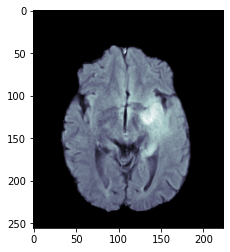

In [32]:
ds = pydicom.dcmread(test_best_images_paths['best_flair_images'][0])
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

In [33]:
ds=pd.merge(sample_submission_df,test_best_images_paths,left_on=['BraTS21ID'],right_on=['files_num'])
ds.head()

,BraTS21ID,MGMT_value,files_num,best_flair_images,best_t1w_images,best_t1wce_images,best_t2w_images
0,1,0.5,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,13,0.5,13,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,15,0.5,15,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
3,27,0.5,27,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
4,37,0.5,37,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...


In [34]:
ds=ds.dropna(axis=0)
ds.drop(['files_num'],axis=1,inplace=True)
ds.to_csv('test_merge_labels_and_paths.csv',index=False)
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 0 to 86
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BraTS21ID          87 non-null     int64  
 1   MGMT_value         87 non-null     float64
 2   best_flair_images  87 non-null     object 
 3   best_t1w_images    87 non-null     object 
 4   best_t1wce_images  87 non-null     object 
 5   best_t2w_images    87 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB


In [35]:
sub_flair_images=load_images(df['best_flair_images'])
sub_t1w_images=load_images(df['best_t1w_images'])
sub_t1wce_images=load_images(df['best_t1wce_images'])
sub_t2w_images=load_images(df['best_t2w_images'])

In [36]:
print(sub_flair_images.shape,type(sub_flair_images))

(87, 256, 256, 1) <class 'numpy.ndarray'>


In [37]:
def prepare_submission_input_pipeline(images):
    AUTOTUNE=tf.data.AUTOTUNE
    test_ds=tf.data.Dataset.from_tensor_slices(images)
    test_ds=test_ds.map(lambda x:x/256).batch(1).cache().prefetch(AUTOTUNE)
    return test_ds

In [38]:
submission_pipeline_flair=prepare_submission_input_pipeline(sub_flair_images)
submission_pipeline_t1w=prepare_submission_input_pipeline(sub_t1w_images)
submission_pipeline_t1wce=prepare_submission_input_pipeline(sub_t1wce_images)
submission_pipeline_t2w=prepare_submission_input_pipeline(sub_t2w_images)

In [39]:
y_pred_submittion=final_prediction(submission_pipeline_flair,submission_pipeline_t1w,submission_pipeline_t1wce,submission_pipeline_t2w)

In [40]:
sample_submission_df['MGMT_value']=y_pred_submittion

In [41]:
sample_submission_df.to_csv('submission.csv',index=False)

In [42]:
sample_submission_df.head()

,BraTS21ID,MGMT_value
0,1,1
1,13,1
2,15,1
3,27,1
4,37,1
